<a href="https://colab.research.google.com/github/Malay19/Advanced-Demand-Forecasting-and-Inventory-Optimization-Using-Machine-Learning/blob/main/Advanced_Demand_Forecasting_and_Inventory_Optimization_Using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.stats import norm

# Load the dataset
grouped_data = pd.read_csv('supply_chain_data.csv')  # Ensure correct path
print(f"Data before processing: {grouped_data.shape}")

# Calculate Demand Variability (Standard Deviation of Demand)
def calculate_demand_variability(data):
    return data['Number of products sold'].std()

# Safety Stock Calculation
def calculate_safety_stock(lead_time, demand_variability, service_level=0.95):
    Z_score = norm.ppf(service_level)  # Z-score for the given service level
    return Z_score * demand_variability * (lead_time ** 0.5)

# Add Safety Stock column
demand_variability = calculate_demand_variability(grouped_data)
grouped_data['Safety Stock'] = grouped_data.apply(
    lambda row: calculate_safety_stock(row['Lead times'], demand_variability), axis=1
)

# Define EOQ calculation
def calculate_eoq(demand, ordering_cost, holding_cost):
    """Calculate Economic Order Quantity (EOQ)."""
    return (2 * ordering_cost * demand / holding_cost) ** 0.5

# Inventory Cost Calculation
def calculate_inventory_cost(demand, holding_cost, ordering_cost, safety_stock):
    """Calculate inventory cost including holding and ordering costs."""
    eoq = calculate_eoq(demand, ordering_cost, holding_cost)
    if eoq == 0:  # Avoid zero EOQ division
        total_ordering_cost = 0
    else:
        total_ordering_cost = (demand / eoq) * ordering_cost
    average_inventory = (eoq / 2) + safety_stock
    total_holding_cost = average_inventory * holding_cost
    return total_holding_cost + total_ordering_cost

# Set cost values for EOQ and inventory calculations
holding_cost_per_unit = 5  # Example holding cost per unit
ordering_cost = 100  # Example ordering cost

# Calculate EOQ and Inventory Cost
grouped_data['EOQ'] = grouped_data.apply(
    lambda row: calculate_eoq(row['Number of products sold'], ordering_cost, holding_cost_per_unit), axis=1
)
grouped_data['Inventory Cost'] = grouped_data.apply(
    lambda row: calculate_inventory_cost(
        row['Number of products sold'], holding_cost_per_unit, ordering_cost, row['Safety Stock']
    ), axis=1
)

# Forecasted Demand using Exponential Smoothing (with fallback for insufficient data)
def forecast_demand(data, sku):
    sku_data = data[data['SKU'] == sku]
    if len(sku_data) < 2:  # Fallback for insufficient data
        return sku_data['Number of products sold'].mean()  # Use mean demand as fallback
    try:
        model = SimpleExpSmoothing(sku_data['Number of products sold'].values)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1)  # Forecast next period
        return forecast[0]
    except Exception as e:
        print(f"Error forecasting demand for SKU {sku}: {e}")
        return sku_data['Number of products sold'].mean()  # Fallback to mean demand

# Add Forecasted Demand column
grouped_data['Forecasted Demand'] = grouped_data['SKU'].apply(lambda sku: forecast_demand(grouped_data, sku))

# Calculate Required Order Quantity
def calculate_required_order(row):
    return max(0, row['Forecasted Demand'] - row['Stock levels'] + row['Safety Stock'])

grouped_data['Required Order Quantity'] = grouped_data.apply(calculate_required_order, axis=1)

# Add Reorder Point
def calculate_reorder_point(row):
    return row['Forecasted Demand'] * row['Lead times'] + row['Safety Stock']

grouped_data['Reorder Point'] = grouped_data.apply(calculate_reorder_point, axis=1)



# Exporting the final result to a CSV
output_path_with_cost = 'inventory_optimization_results.csv'
grouped_data.to_csv(output_path_with_cost, index=False)
print(f"Final results saved to: {output_path_with_cost}")

# Summary Statistics
summary_stats = {
    "Average Safety Stock": grouped_data['Safety Stock'].mean(),
    "Average EOQ": grouped_data['EOQ'].mean(),
    "Average Inventory Cost": grouped_data['Inventory Cost'].mean(),
    "Average Forecasted Demand": grouped_data['Forecasted Demand'].mean(),
    "Total Required Order Quantity": grouped_data['Required Order Quantity'].sum(),
    "Total Inventory Cost": grouped_data['Inventory Cost'].sum()
}

# Save summary statistics to a separate CSV
summary_stats_df = pd.DataFrame(list(summary_stats.items()), columns=['Metric', 'Value'])
summary_stats_df.to_csv('inventory_summary_statistics.csv', index=False)
print("Summary statistics saved to: inventory_summary_statistics.csv")

# Add Forecasted Demand column
grouped_data['Forecasted Demand'] = grouped_data['SKU'].apply(lambda sku: forecast_demand(grouped_data, sku))

# Exporting the final result to a CSV
output_path_with_cost = 'final_inventory_optimization_results.csv'
grouped_data.to_csv(output_path_with_cost, index=False)
print(f"Final results saved to: {output_path_with_cost}")



# Summary Statistics
print("\nSummary Statistics:")
print(f"Average Safety Stock: {grouped_data['Safety Stock'].mean():.2f}")
print(f"Average EOQ: {grouped_data['EOQ'].mean():.2f}")
print(f"Average Inventory Cost: {grouped_data['Inventory Cost'].mean():.2f}")
print(f"Average Forecasted Demand: {grouped_data['Forecasted Demand'].mean():.2f}")

Data before processing: (4000, 24)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:1419: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:1419: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) 

Final results saved to: inventory_optimization_results.csv
Summary statistics saved to: inventory_summary_statistics.csv


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:1419: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:1419: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) 

Final results saved to: final_inventory_optimization_results.csv

Summary Statistics:
Average Safety Stock: 1861.40
Average EOQ: 126.10
Average Inventory Cost: 9937.53
Average Forecasted Demand: 455.44


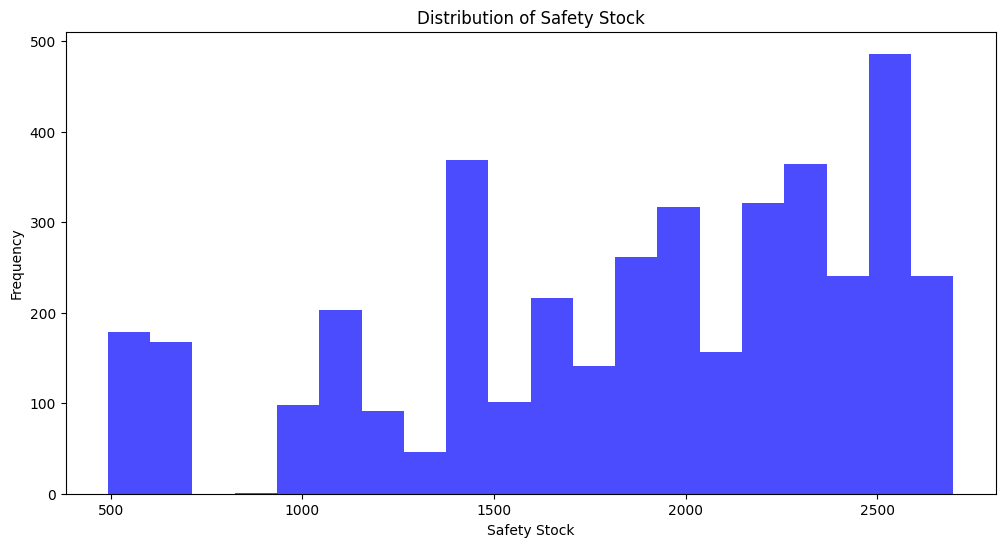

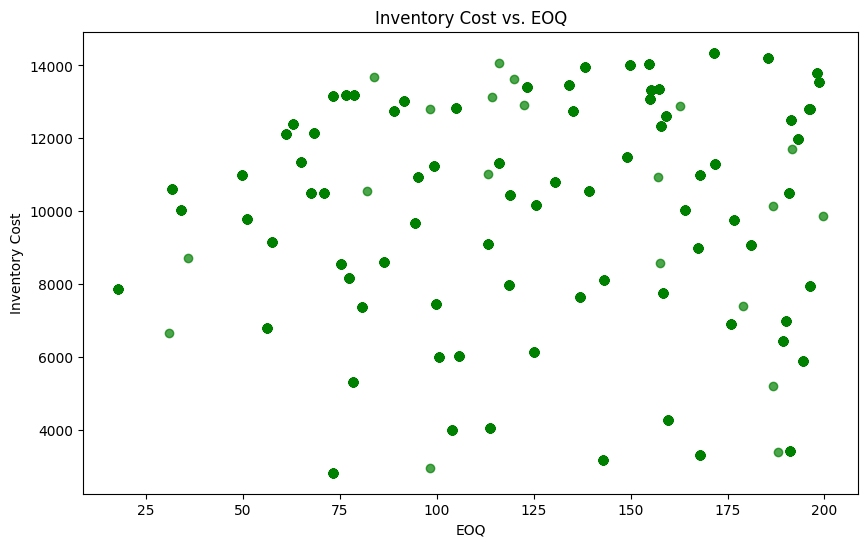

In [ ]:
# Visualizations for Better Insights
# 1. Safety Stock Distribution
plt.figure(figsize=(12, 6))
plt.hist(grouped_data['Safety Stock'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Safety Stock')
plt.xlabel('Safety Stock')
plt.ylabel('Frequency')
plt.show()

# 2. Inventory Cost vs. EOQ
plt.figure(figsize=(10, 6))
plt.scatter(grouped_data['EOQ'], grouped_data['Inventory Cost'], color='green', alpha=0.7)
plt.title('Inventory Cost vs. EOQ')
plt.xlabel('EOQ')
plt.ylabel('Inventory Cost')
plt.show()

# 3. Forecasted Demand vs. Actual Demand
# plt.figure(figsize=(30, 100))
# plt.plot(grouped_data['Number of products sold'], label='Actual Demand', color='blue')
# plt.plot(grouped_data['Forecasted Demand'], label='Forecasted Demand', color='red', linestyle='--')
# plt.title('Actual vs. Forecasted Demand')
# plt.xlabel('SKU')
# plt.ylabel('Demand')
# plt.legend()
# plt.show()

In [ ]:
# Import required libraries
import pandas as pd
import plotly.express as px

# Load the dataset
supply_data = pd.read_csv("supply_chain_data.csv")

# Ensure the 'EOQ' column exists (if not, calculate it)
if 'EOQ' not in supply_data.columns:
    # Example EOQ calculation (replace with your actual logic)
    holding_cost_per_unit = 5  # Example holding cost per unit
    ordering_cost = 100  # Example ordering cost
    supply_data['EOQ'] = (2 * supply_data['Order quantities'] * ordering_cost / holding_cost_per_unit) ** 0.5

# Extract the top 10 rows for comparison
comparison_columns = supply_data[['SKU', 'EOQ', 'Order quantities']]
top_10_comparison = comparison_columns.head(10)

# Create a bar plot to compare EOQ and Order Quantities for the top 10 SKUs
fig = px.bar(top_10_comparison, x='SKU', y=['EOQ', 'Order quantities'],
             title='Comparison of EOQ and Order Quantities for Top 10 SKUs',
             labels={'value': 'Quantity', 'variable': 'Metric'},  # Customize axis labels
             barmode='group')  # Grouped bar chart

# Customize the layout
fig.update_layout(
    title_x=0.5,  # Center the title
    xaxis_title="SKU",  # X-axis label
    yaxis_title="Quantity",  # Y-axis label
    legend_title="Metric"  # Legend title
)

# Display the plot
fig.show()

In [ ]:
# Import required libraries
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Load the dataset
supply_data = pd.read_csv("supply_chain_data.csv")

# Prepare the data for revenue analysis
# Example: Group by 'Customer demographics' and 'Product type' to calculate average and total revenue
revenue_avg_by_demo_prod = supply_data.groupby(['Customer demographics', 'Product type'])['Revenue generated'].mean().reset_index()
revenue_sum_by_demo_prod = supply_data.groupby(['Customer demographics', 'Product type'])['Revenue generated'].sum().reset_index()

# Create a palette of different colors for each product type
colors = px.colors.qualitative.Set3

# Create a subplot with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=('Average Revenue', 'Total Revenue'))

# Plot for average revenue
for i, product_type in enumerate(revenue_avg_by_demo_prod['Product type'].unique()):
    subset = revenue_avg_by_demo_prod[revenue_avg_by_demo_prod['Product type'] == product_type]
    fig.add_trace(
        go.Bar(
            x=subset['Customer demographics'],
            y=subset['Revenue generated'],
            name=product_type,
            marker_color=colors[i]
        ),
        row=1, col=1
    )

# Plot for total revenue without legend
for i, product_type in enumerate(revenue_sum_by_demo_prod['Product type'].unique()):
    subset = revenue_sum_by_demo_prod[revenue_sum_by_demo_prod['Product type'] == product_type]
    fig.add_trace(
        go.Bar(
            x=subset['Customer demographics'],
            y=subset['Revenue generated'],
            showlegend=False,  # Hide legend for this subplot
            marker_color=colors[i]
        ),
        row=1, col=2
    )

# Beautify the subplot and show the legend for the first subplot
fig.update_layout(
    title='Revenue Analysis by Customer Demographics and Product Type',
    xaxis=dict(title='Customer Demographics'),
    yaxis=dict(title='Revenue'),
    xaxis2=dict(title='Customer Demographics'),
    yaxis2=dict(title='Revenue'),
    title_x=0.5,
    showlegend=True  # Show legend for the first subplot
)

# Show the subplot
fig.show()

In [ ]:
# lead time optimization analysis

avg_lead_times_transport = supply_data.groupby(['Transportation modes'])['Lead times'].mean().reset_index()

fig = px.bar(avg_lead_times_transport, x='Transportation modes', y='Lead times',
             labels={'Transportation modes': 'Transportation Mode', 'Lead times': 'Average Lead Time'},
             title='Average Lead Times by Transportation Mode')

# Customize the color scale for bars
color_scale = px.colors.qualitative.Set3  # You can choose a different color scale
fig.update_traces(marker_color=color_scale)

# Customize the layout for beautification
fig.update_layout(
    title=dict(text='Average Lead Times by Transportation Mode', x=0.5),
    xaxis_title='Transportation Mode',
    yaxis_title='Average Lead Time',
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
    font=dict(family="Arial", size=14),
    showlegend=False  # Remove legend
)

# Show the plot
fig.show()

In [ ]:
#average lead times by route

import plotly.express as px

avg_lead_times_route = supply_data.groupby(['Routes'])['Lead times'].mean().reset_index()

# Assuming you have the avg_lead_times_route DataFrame already defined
fig = px.bar(avg_lead_times_route, x='Routes', y='Lead times',
             labels={'Routes': 'Route', 'Lead times': 'Average Lead Time'},
             title='Average Lead Times by Route')

# Customize the color scale for bars
color_scale = px.colors.qualitative.Set3  # You can choose a different color scale
fig.update_traces(marker_color=color_scale)

# Customize the layout for beautification
fig.update_layout(
    title=dict(text='Average Lead Times by Route', x=0.5),
    xaxis_title='Route',
    yaxis_title='Average Lead Time',
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
    font=dict(family="Arial", size=14),
    showlegend=False  # Remove legend
)

# Show the plot
fig.show()